
https://en.wikipedia.org/wiki/Dreamachine

MIAM

The goal is here :

* to generate a complex visual stimulation flickering on average at 12 Hz

* to project it on a retinotopic space to maximise the psychelic effect

<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
from __future__ import division, print_function
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)
from IPython.display import display, HTML
def show_video(filename): 
    return HTML(data='<video src="{}" loop autoplay width="600" height="600"></video>'.format(filename))
# https://docs.python.org/3/library/warnings.html#warning-filter
import warnings
warnings.simplefilter("ignore")

%load_ext autoreload
%autoreload 2

## a flickering motion cloud

A simple way to generate a flickering stimulus is to combine two sinusiods going in two opposite directions, following :

$$
\sin(x + v \cdot x) + \sin(x - v \cdot x) = 
$$


A first solution is to use an existing library for generating band-pass filtered noise, with a parameterization which fits well natural scenes:

https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py

In [2]:
import os
name = 'alpha'
DOWNSCALE = 2
import MotionClouds as mc

In [3]:
mc.figpath = '../files/2022-01-30-dreamachine'
os.makedirs(mc.figpath, exist_ok=True)

Let's explore parameters:

In [4]:
mc.envelope_gabor?

Signature:
mc.envelope_gabor(
    fx,
    fy,
    ft,
    V_X=1.0,
    V_Y=0.0,
    B_V=0.5,
    sf_0=0.125,
    B_sf=0.1,
    loggabor=True,
    theta=0.0,
    B_theta=0.19634954084936207,
    alpha=0.0,
    **kwargs,
)
Docstring:
Returns the Motion Cloud kernel, that is the product of:
    * a speed envelope
    * an orientation envelope
    * an orientation envelope
File:      /usr/local/lib/python3.9/site-packages/MotionClouds.py
Type:      function


To find that which will best will what we wish to do:

In [5]:
T_movie = 2.4 # period in seconds
fps = 120 # frames per second
sf_0 = 0.05 # spatial frequency per period
TF_0 = 12.  # peak temporal frequency
N_X, N_Y, N_frame = 256//DOWNSCALE, 256//DOWNSCALE, int(T_movie*fps)
print(f'{N_X=}, {N_Y=}, {N_frame=}')

N_X=128, N_Y=128, N_frame=288


In [6]:
fx, fy, ft = mc.get_grids(N_X, N_Y, N_frame)

tf_0 = TF_0/fps # temporal frequency per period
V_X = tf_0 / sf_0
B_V = 0.12
theta = 0
B_theta = .1
print(f'{V_X=}, {sf_0=}, {tf_0=}')

V_X=2.0, sf_0=0.05, tf_0=0.1


In [7]:
z_1 = mc.envelope_gabor(fx, fy, ft, V_X=V_X, sf_0=sf_0, B_V=B_V, theta=theta, B_theta=B_theta)

movie_1 = mc.rectif(mc.random_cloud(z_1))

In [8]:
name_ = name + '_1'
#mc.anim_save(movie_1, os.path.join(mc.figpath, name_))
mc.figures(z_1, name_, figpath=mc.figpath)
mc.in_show_video(name_, figpath=mc.figpath)

2022-02-02 12:10:08.004 Python[56981:8280112] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/3p/m0g52j9j69z3gj8ktpgg1dm00000gn/T/org.python.python.savedState


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
built with Apple clang version 13.0.0 (clang-1300.0.29.3)
configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enab

In [9]:
z_2 = mc.envelope_gabor(fx, fy, ft, V_X=-V_X, sf_0=sf_0, B_V=B_V, theta=theta, B_theta=B_theta)
z_12 = z_1 + z_2
#movie_2 = mc.rectif(mc.random_cloud(z_2))
#movie_12 = mc.rectif(movie_1 + movie_2)

name_ = name + '_12'
#mc.anim_save(movie_12, os.path.join(mc.figpath, name_))
mc.figures(z_12, name_, figpath=mc.figpath)
mc.in_show_video(name_, figpath=mc.figpath)

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
built with Apple clang version 13.0.0 (clang-1300.0.29.3)
configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enab

The combination of both wavec indeedd generates a flickering effect, but to increase it, let's make the wave more sinusoid-like by making the envelope more "tight":

In [10]:
tightness = 8.
z_1 = mc.envelope_gabor(fx, fy, ft, V_X=V_X, sf_0=sf_0, B_sf=0.1/tightness, B_V=B_V/tightness, theta=theta, B_theta=B_theta)
z_2 = mc.envelope_gabor(fx, fy, ft, V_X=-V_X, sf_0=sf_0, B_sf=0.1/tightness, B_V=B_V/tightness, theta=theta, B_theta=B_theta)

z_12 = z_1 + z_2

name_ = name + '_12_tight'
#mc.anim_save(movie_12, os.path.join(mc.figpath, name_))
mc.figures(z_12, name_, figpath=mc.figpath)
mc.in_show_video(name_, figpath=mc.figpath)

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
built with Apple clang version 13.0.0 (clang-1300.0.29.3)
configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enab


This indeed looks better, but we may also follow a simpler route by generating our custom envelope.

## custom cloud


Let's inspire us by the function which defines the enveloppe :

In [11]:
mc.frequency_radius?

Signature: mc.frequency_radius(fx, fy, ft, ft_0=inf, clean_division=False)
Docstring:
Returns the frequency radius. To see the effect of the scaling factor run
'test_color.py'
File:      /usr/local/lib/python3.9/site-packages/MotionClouds.py
Type:      function


and to define a custom one 

In [12]:
tf_0

0.1

In [13]:
ft.min(), ft.max()

(-0.5, 0.4965277777777778)

In [14]:
B_sf = .05
B_tf = .1
B_theta = .1
theta = np.pi*(3 - np.sqrt(5)) # https://en.wikipedia.org/wiki/Golden_angle


In [15]:
def envelope_alpha(fx, fy, ft, tf_0=tf_0, B_tf=B_tf, sf_0=sf_0, B_sf=B_sf, theta=theta, B_theta=B_theta):
    #f_radius = mc.frequency_radius(fx, fy, ft, ft_0=1.0, clean_division=True)    
    ft_ = ft + 1.0*(ft==0.) # to avoid numerical errors
    #env = 1./np.abs(ft_)*np.exp(-.5*(np.log((ft_/tf_0)**2))/((np.log((tf_0+B_tf)/tf_0))**2))    
    env = np.exp(-.5*(ft_-tf_0)**2/B_tf**2)    
    env *= mc.envelope_orientation(fx, fy, ft, theta=theta, B_theta=B_theta)
    env *= mc.envelope_radial(fx, fy, ft, sf_0=sf_0, B_sf=B_sf)
        
    return env

In [16]:

z_pure = envelope_alpha(fx, fy, ft, tf_0=tf_0, B_tf=B_tf, B_sf=B_sf, theta=theta, B_theta=B_theta)

name_ = name + '_pure'
mc.figures(z_pure, name_, figpath=mc.figpath, recompute=True)
mc.in_show_video(name_, figpath=mc.figpath)

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
built with Apple clang version 13.0.0 (clang-1300.0.29.3)
configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enab

## retinotopic mapping

We can directly acess the movie as a 3D `ndarray`:

In [17]:
movie_pure = mc.rectif(mc.random_cloud(z_pure))

One may want to project it on retinotopic coordinates to give a psychedelic effect...

Following [this answer](https://stackoverflow.com/a/49630831/234547), it's pretty easy to take one image and to project it to a retinotopic map. In our case, there are no color, so it's even easier...

In [18]:
# get coordinates of boxes in the mesh :
phi = np.linspace(0, 2*np.pi, movie_pure.shape[1])
r = np.linspace(0, 1, movie_pure.shape[0])
Phi, R = np.meshgrid(phi, r)

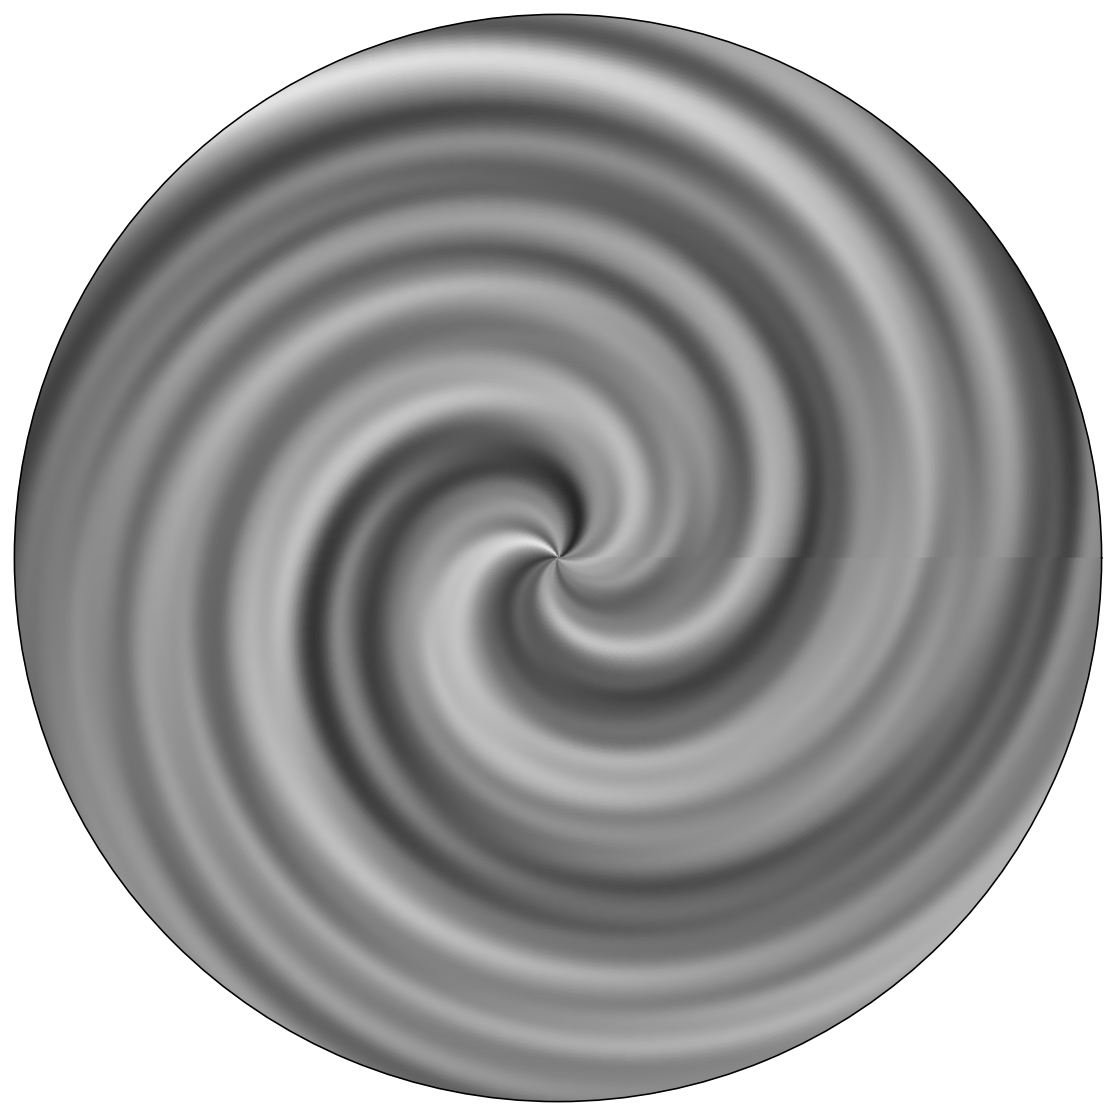

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width), subplot_kw=dict(polar=True))
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html
# https://matplotlib.org/devdocs/gallery/images_contours_and_fields/pcolormesh_grids.html
m = ax.pcolormesh(Phi, R, movie_pure[:, :, 0], shading='gouraud', vmin=movie_pure.min(), vmax=movie_pure.max(), 
                  edgecolors='none', linewidth=0, cmap=plt.gray())
ax.set_xticks([])
ax.set_yticks([]);

In [20]:
ax.axis()

(0.0, 6.283185307179586, 0.0, 1.0)

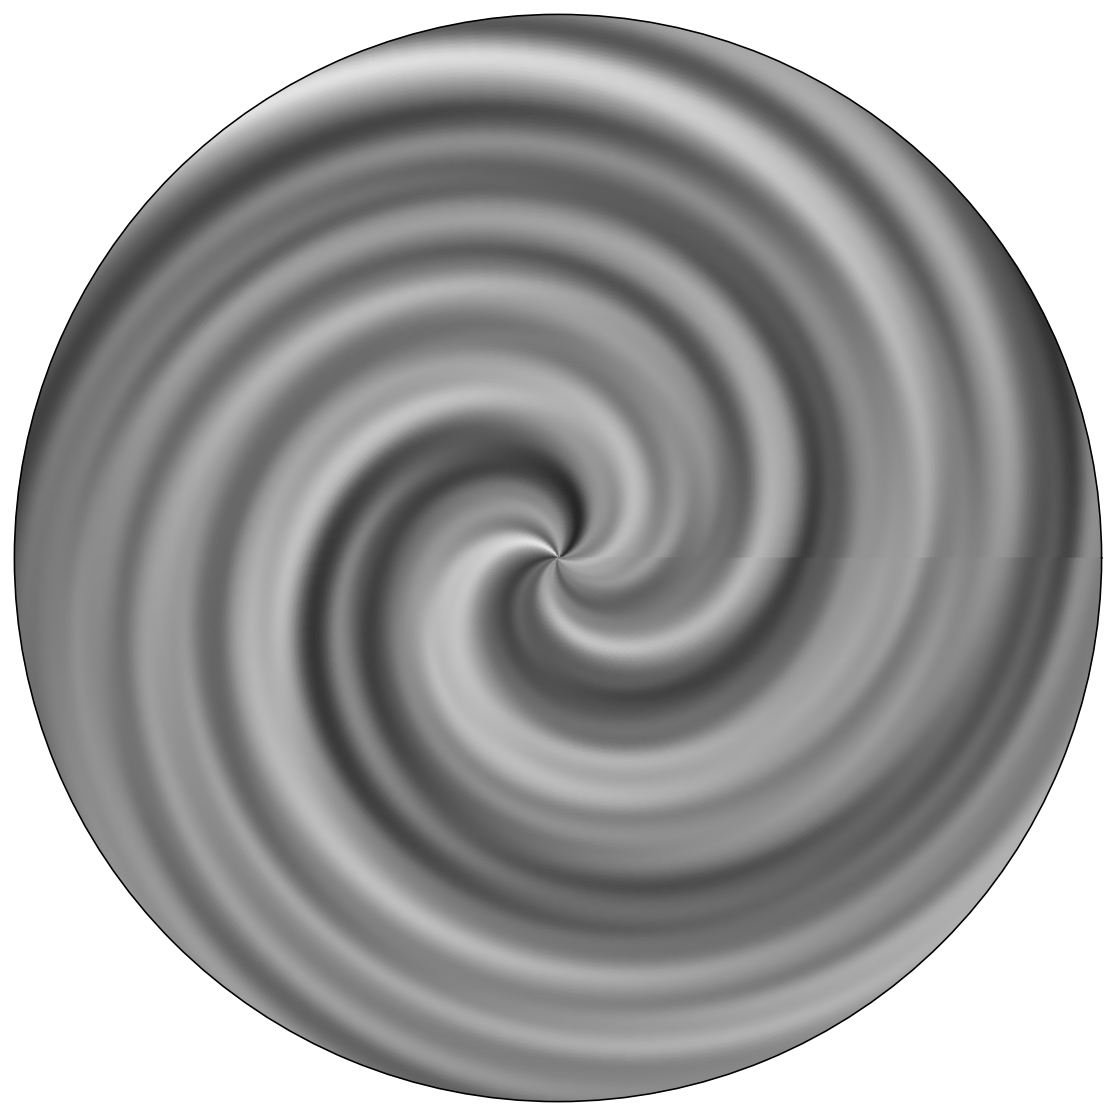

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width), subplot_kw=dict(polar=True))
#fig.subplots_adjust(bottom=0.4, left=.3, right=0.6, top=0.6);
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html
# https://matplotlib.org/devdocs/gallery/images_contours_and_fields/pcolormesh_grids.html
m = ax.pcolormesh(Phi, R, movie_pure[:, :, 0], shading='gouraud', 
                  vmin=movie_pure.min(), vmax=movie_pure.max(), 
                  edgecolors='none', cmap=plt.gray())
#ax.margins(y=-0.2)
ax.set_xticks([])
ax.set_yticks([]);

## DREAMACHINE videos

Following a [previous post](https://laurentperrinet.github.io/sciblog/posts/2019-10-07-neurostories-videos-of-my-talk.html), we can make a one-cell code to create and display the video (see also the [doc](https://zulko.github.io/moviepy/getting_started/working_with_matplotlib.html#simple-matplotlib-example)):

In [22]:

import numpy as np
import gizeh as gz
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

W, H = 1000, 600
def create_movie(figname, r = 16,
                    B_tf = .1,
                    B_sf = .05,
                    B_theta = .1,
                    theta = np.pi*(3 - np.sqrt(5)), # https://en.wikipedia.org/wiki/Golden_angle
                 
                 T_movie = T_movie,
                 fps = fps,
                 W=W, H=H):
    

    z_pure = envelope_alpha(fx, fy, ft, tf_0=tf_0, B_tf=B_tf, B_sf=B_sf, theta=theta, B_theta=B_theta)

    name_ = name + '_pure'
    mc.figures(z_pure, name_, figpath=mc.figpath, recompute=True)
    mc.in_show_video(name_, figpath=mc.figpath)
    
    def make_frame(t):
        print(t)
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width), subplot_kw=dict(polar=True))
        #fig.subplots_adjust(bottom=0.4, left=.3, right=0.6, top=0.6);
        # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html
        # https://matplotlib.org/devdocs/gallery/images_contours_and_fields/pcolormesh_grids.html
        m = ax.pcolormesh(Phi, R, movie_pure[:, :, t], shading='gouraud', vmin=movie_pure.min(), vmax=movie_pure.max(), 
                      edgecolors='none', linewidth=0, cmap=plt.gray())
        #ax.margins(y=-0.2)
        ax.set_xticks([])
        ax.set_yticks([])
        
        return mplfig_to_npimage(fig)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.write_videofile(path2(figname), fps=fps)
    return clip

figname = os.path.join(mc.figpath, 'pure_alpha.mp4')
if not os.path.isfile(figname): 
    clip = create_movie(figname)
clip = mpy.VideoFileClip(figname)
clip.ipython_display(fps=fps, autoplay=True, loop=True)

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
built with Apple clang version 13.0.0 (clang-1300.0.29.3)
configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enab

NameError: name 'duration' is not defined

## some book keeping for the notebook

In [ ]:
%pwd

In [ ]:
mc.figpath

In [ ]:
%ls -ltr {mc.figpath}

In [ ]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,scipy,pillow,imageio  -r -g -b